# LGPEKF Attitude Filter (Lie Group Projected EKF)

This filter uses a geometrically accurate measurement correction, that is appropriate for measurements on a manifold. In this case, we measure the attitude of the vehicle relative to the magnetic field and also we measure the direction of the gravity. When the acceleration is near g, it can be assumed that the vehicle is on the ground or in a stable hover and, the direction of gravity can be use to correct the attitude.

Although the measurements are actually vectors, they are transformed into elements of SO3. One represenation of SO3 is a direction cosine matrix. From the Lie Group Extended Kalman Filter, we use a slightly modified correction term so that it is right invariant:

$$\hat{X}_{k|k} = \hat{X}_{k|k-1}\exp_{G} \left(
    K \log_{G'}\left(
        h(\hat{X}_{k|k-1}) T_y(y_k)^{-1}
    \right)
\right) $$

Here $T_y$ represents the mapping of the true measurement to the manifold. Although a bijection does not exist between SO3 and the vector measurements, a map can be constructed that is closest to the original state, so that the measurements only modifies the states that it is observing. For instance, if $y$ is measuring the magnetic heading, we wish to only induce a rotation about the down direction in the navigation frame, so we choose $T_y$ so that $\eta = h(\hat{X}_{k|k-1}) T_y(y_k)^{-1} = R_3(\xi_3)$, where $R_3$ represents a rotation around the world 3 axis.

$$ H = \frac{\partial}{\partial \boldsymbol{\xi}} \log_{G'}^{\vee} \left(
        h(\hat{X}_{k|k-1}) T_y(y_k)^{-1}
    \right)
$$

### TODO

* Correctly handle noise on manifolds.
* Generate C code.

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '..')

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy.integrate
from IPython.display import Image
from casadi.tools.graph import graph
import casadi as ca

# this library
from pyecca.so3.mrp import Mrp
from pyecca.so3.quat import Quat
from pyecca.so3.dcm import Dcm


def draw_graph(x):
    g = graph.dotgraph(x)
    #g.set('dpi', 300)
    png = g.create('dot', 'png')
    return Image(png)

## Filter Derivation

This needs to be cleaned up.

In [2]:
class SO3xR3(ca.SX):
    """
    Direct product of SO3 and R3
    """
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        assert self.shape == (6, 1)
        self.r = Mrp(self[0:3])
        self.b = self[3:6]

    def inv(self):
        return self.__class__(ca.vertcat(self.r.inv(), -self.b))
    
    def __mul__(self, other):
        r = self.r*other.r
        b  = self.b + other.b
        return self.__class__(ca.vertcat(r, b))

    @classmethod
    def exp(cls, xi):
        return cls(ca.vertcat(Mrp.exp(xi[0:3]), xi[3:6]))

    def log(self):
        return ca.vertcat(self.r.log(), self.b)

    def shadow_if_needed(self):
        r = ca.if_else(ca.norm_2(self.r) >1, self.r.shadow(), self.r)
        return self.__class__(ca.vertcat(r, self.b))

### Prediction



In [3]:
n_x = 6

x = SO3xR3(ca.SX.sym('x', 6, 1))
x_h = SO3xR3(ca.SX.sym('x_h', 6, 1))
q = Quat(ca.SX.sym('q', 4, 1))
omega_b = ca.SX.sym('omega_b', 3, 1)

#w = ca.SX.sym('w', 3, 1)
x_dot = ca.vertcat(x.r.derivative(omega_b - x.b), ca.SX([0, 0, 0]))
f_dynamics = ca.Function(
    'dynamics', [x, omega_b],
    [x_dot],
    ['x', 'omega_b'], ['x_dot'])

f_dynamics_T = ca.Function(
    'dynamics_T', [x, omega_b],
    [x_dot.T],
    ['x', 'omega_b'], ['x_dot'])

eta = SO3xR3(ca.SX.sym('eta', 6, 1)) # (right)
f = ca.Function('f', [eta, x_h], [ca.vertcat(-ca.mtimes(x_h.r.to_dcm(), eta.b), ca.SX.zeros(3))])
f_J = ca.jacobian(f(eta, x_h), eta)

# note, the estimated error is always zero when propagating the
# covariance, we might want the F without zero eta_R, when doing
# the LGEKF covariance correction term
F = ca.sparsify(ca.substitute(f_J, eta, ca.SX.zeros(n_x)))
f_F = ca.Function('F', [x_h], [F], ['x_h'], ['F'])
w_att = ca.SX.sym('w_att')
Q = ca.sparsify((w_att*ca.norm_2(omega_b)*ca.diag([1, 1, 1, 0, 0, 0]))**2)

# find sparsity pattern of P
P0 = ca.SX.sym('P0', ca.Sparsity.diag(6))
P_sparse = P0
# loop for number of states to ensure covariance has fully propagated
for i in range(n_x):
    P_sparse += ca.mtimes(F, P_sparse) + ca.mtimes(P_sparse, F.T) + Q
PU = ca.SX.sym('P', ca.triu(P_sparse).sparsity())

# fix PSD
def ldl_psd_fix(M):
    # LDL^T decomp to force PSD
    D, LT, p = ca.ldl(M, False)
    D_fix = D - (D < 0)*D
    L = LT.T + ca.SX.eye(6)
    return ca.mtimes([L, ca.diag(D_fix), L.T])

# covariance prediction
P = ca.triu2symm(PU)
dP = ca.mtimes(F, P) + ca.mtimes(P, F.T) + Q
dP = ca.substitute(dP, eta, ca.SX.zeros(6))
#dP = ldl_psd_fix(dP)

dP = ca.sparsify(ca.triu2symm(ca.triu(dP))) # force symmetric, simplifies graph
f_dP = ca.Function('dP', [x_h, PU, w_att, omega_b], [dP], ['x_h', 'PU', 'w_att', 'omega_b'], ['dP'])

def rk4(f, t, y, h):
    """Runge Kuta 4th order integrator"""
    k1 = h*f(t, y)
    k2 = h*f(t + h/2, y + k1/2)
    k3 = h*f(t + h/2, y + k2/2)
    k4 = h*f(t + h, y + k3)
    return ca.simplify(y + (k1 + 2*k2 + 2*k3 + k4)/6)

# find condition number
def condition_number(P):
    eig = ca.fabs(ca.eig_symbolic(P))
    min_eig = ca.mmin(eig)
    return ca.if_else(min_eig < 1e-5, ca.inf, ca.mmax(eig)/ca.mmin(eig))

#f_cond = ca.Function('cond', [x, u, PU, R], [condition_number(Si),],
#                       ['x', 'u', 'PU', 'R'], ['cond'])

dt = ca.SX.sym('dt')
t = ca.SX.sym('t')

P1 = rk4(lambda t, y: f_dP(x_h, y, w_att, omega_b), t, P, dt)
f_predict_P = ca.Function(
    'predict_P',
    [x_h, PU, w_att, omega_b, dt],
    [P1],
    ['x_h', 'P0', 'w_att', 'omega_b', 'dt'], ['P1'])

x1 = rk4(lambda t, y: f_dynamics(y, omega_b), t, x, dt)
f_predict_x = ca.Function(
    'x_predict',
    [x, omega_b, dt],
    [x1],
    ['x0', 'omega_b', 'dt'],
    ['x1']
    )

#### Square Root Covariance Prediction

In [4]:
def find_X(F, Q):
    """
    Finds a sqrt factorization of the continuous time covariance
    propagation equations. Requires solving a linear system of equations
    to keep the sqrt lower triangular.
    
    'A Square Root Formulation of the Kalman Covariance Equations', Andrews 68
    
    F: dynamics matrix
    Q: process noise matrix
    
    returns:
    W_dot_sol: sqrt of P deriative, lower triangular
    W: symbolic sqrt(P) matrix
    """
    n_x = F.shape[0]
    W = ca.SX.sym('W', ca.Sparsity_lower(n_x))
    XL = ca.SX.sym('X', ca.Sparsity_lower(n_x))
    X = (XL - XL.T)
    for i in range(n_x):
        X[i, i] = 0
    W_dot = ca.mtimes(F, W) + ca.mtimes(Q/2 + X, ca.inv(W).T)

    # solve for XI that keeps W dot lower triangular
    y = ca.vertcat(*ca.triu(W_dot, False).nonzeros())
    x_dep = []
    for i, xi in enumerate(XL.nonzeros()):
        if ca.depends_on(y, xi):
            x_dep += [xi]
    x_dep = ca.vertcat(*x_dep)
    A = ca.jacobian(y, x_dep)
    for i, xi in enumerate(XL.nonzeros()):
        assert not ca.depends_on(A, xi)
    b = -ca.substitute(y, x_dep, 0)
    x_sol = ca.solve(A, b)

    X_sol = ca.SX(X)
    for i in range(x_dep.shape[0]):
        X_sol = ca.substitute(X_sol, x_dep[i], x_sol[i])
    X_sol = ca.sparsify(X_sol)
    W_dot_sol = ca.mtimes(F, W) + ca.mtimes(Q/2 + X_sol, ca.inv(W).T)

    return W_dot_sol, W

In [5]:
W_dot_sol, W = find_X(F, Q)
f_W_dot = ca.Function('W_dot', [x_h, W, w_att, omega_b], [W_dot_sol])
f_W_dot_lt = ca.Function('W_dot_lt', [x_h, W, w_att, omega_b], [ca.tril(W_dot_sol)])
W1 = rk4(lambda t, y: f_W_dot_lt(x_h, y, w_att, omega_b), t, W, dt)

f_predict_W = ca.Function(
    'predict_W',
    [x_h, W, w_att, omega_b, dt],
    [W1],
    ['x_h', 'W0', 'w_att', 'omega_b', 'dt'], ['W1'])

def test_sqrt_cov_prop():
    W_check = np.random.randn(6, 6)
    Q_check = np.diag([0.1, 0.1, 0.1, 0, 0, 0])
    xh_check = np.array([0.1, 0.2, 0.3, 0.1, 0.2, 0.3])
    omega_check = np.array([1, 2, 3])
    dt_check = 0.1
    w_att_check = 0.01

    f_check = ca.Function('check', [x_h, W, w_att, omega_b], [ca.mtimes([F, W, W.T]) + ca.mtimes([W, W.T, F.T]) + Q - ca.mtimes(W, W_dot_sol.T) - ca.mtimes(W_dot_sol, W.T)])
    assert np.linalg.norm(f_check(xh_check, W_check, 1, [1, 1, 1])) < 1e-5
    assert np.linalg.norm(ca.triu(f_W_dot(xh_check, W_check, 1, [1, 1, 1]), False)) < 1e-5

    P_test = np.eye(6)
    P_test[3, 0] = 0.1
    P_test[1, 2] = 0.3
    P_test = P_test + P_test.T
    xh_test = np.random.randn(6)
    W_test = np.linalg.cholesky(P_test)
    assert np.linalg.norm(W_test.dot(W_test.T) - P_test) < 1e-10

    P1_test = f_predict_P(xh_test, P_test, w_att_check, omega_check, dt_check)
    W1_test = f_predict_W(xh_test, W_test, w_att_check, omega_check, dt_check)
    assert np.linalg.norm(ca.mtimes(W1_test, W1_test.T) - P1_test) < 1e-5
    print('PASS')

test_sqrt_cov_prop()

PASS


### Magnetometer Correction

For the case of the magnetic heading, we calculate:

\begin{align} H_{mag} &= \frac{\partial}{\partial \boldsymbol{\xi}} \log_{G'}^{\vee}(R_3(\xi_3)) \\
&=  \frac{\partial}{\partial \boldsymbol{\xi}} \xi_3 \\
&= \begin{pmatrix} 0 & 0 & 1\end{pmatrix}
\end{align}

In [6]:
H_mag = ca.SX(1, 6)
H_mag[0, 2] = 1

B_n = ca.SX.sym('B_n', 3, 1)

f_measure_hdg = ca.Function('measure_hdg', [x, B_n], [ca.mtimes(x.r.to_dcm().T, B_n)])
yh_mag = f_measure_hdg(x_h, B_n)
w_mag = ca.SX.sym('w_mag')
gamma = ca.acos(yh_mag[2]/ca.norm_2(yh_mag))
w = w_mag + ca.norm_2(ca.diag(P)[1:3])  # roll/pitch and mag uncertainty contrib. to projection uncertainty
h = ca.fmax(ca.sin(gamma), 1e-3)
R_mag = (2*ca.asin(w/(2*h)))**2

S_mag = ca.mtimes([H_mag, P, H_mag.T]) + R_mag
K_mag = ca.mtimes([P, H_mag.T, ca.inv(S_mag)])
P_mag = P - ca.mtimes([K_mag, H_mag, P])

# josepph form
#M = (np.eye(6) - ca.mtimes(K_mag, H_mag))
#P_mag = ca.mtimes([M, P, M.T]) + ca.mtimes([K_mag, R_mag, K_mag.T])

#P_mag = ldl_psd_fix(P_mag)
P_mag = ca.triu2symm(ca.triu(P_mag)) # force symmetric, simplifies graph

y_b = ca.SX.sym('y_b', 3, 1)

R_nb = x_h.r.to_dcm()
y_n = ca.mtimes(R_nb, y_b)
v_n = ca.cross(y_n, B_n)/ca.norm_2(y_n)/ca.norm_2(B_n)
norm_v = ca.norm_2(v_n)
vh_n = v_n/norm_v
omega_c_mag_n = ca.sparsify(ca.if_else(norm_v > 0, vh_n[2]*ca.asin(norm_v)*ca.SX([0, 0, 1]), ca.SX([0, 0, 0])))

x_mag = SO3xR3.exp(ca.mtimes(K_mag, omega_c_mag_n[2]))*x_h

# ignore correction when near singular point
x_mag = ca.if_else(gamma > 1, x_mag, x_h)  
P_mag = ca.if_else(gamma > 1, P_mag, P)

f_correct_mag = ca.Function('correct_mag', [x_h, PU, y_b, B_n, w_mag], [x_mag, P_mag])

#### Square Root Factorization

In [7]:
def sqrt_correct(Rs, H, W):
    """
    source: Fast Stable Kalman Filter Algorithms Utilising the Square Root, Steward 98
    Rs: sqrt(R)
    H: measurement matrix
    W: sqrt(P)
    @return sqrt(P+) = sqrt((I - KH)P)
    """
    n_x = H.shape[1]
    n_y = H.shape[0]
    B = ca.sparsify(ca.blockcat(Rs, ca.mtimes(H, W), ca.SX.zeros(n_x, n_y), W))
    # qr  by default is upper triangular, so we transpose inputs and outputs
    B_Q, B_R = ca.qr(B.T)  # B_Q orthogonal, B_R, lower triangular
    B_Q = B_Q.T
    B_R = B_R.T
    K = ca.mtimes(B_R[n_y:, :n_y], ca.inv(B_R[:n_y, :n_y]))
    Wp = B_R[n_y:, n_y:]
    return Wp, K

In [8]:
w = w_mag + ca.norm_2(ca.diag(W)[1:3])  # roll/pitch and mag uncertainty contrib. to projection uncertainty
Rs_mag = 2*ca.asin(w/(2*h))
W_mag, K_mag = sqrt_correct(Rs_mag, H_mag, W)
x_mag = SO3xR3.exp(ca.mtimes(K_mag, omega_c_mag_n[2]))*x_h

# ignore correction when near singular point
x_mag = ca.if_else(w/2 < h, x_mag, x_h)  
W_mag = ca.if_else(w/2 < h, W_mag, W)
f_correct_mag_sqrt = ca.Function('correct_mag_sqrt', [x_h, W, y_b, B_n, w_mag], [x_mag, W_mag])

def test_mag_sqrt_correct():
    x_sqrt_test_mag, W_test_mag = f_correct_mag_sqrt([0, 0, 0, 0, 0, 0], np.eye(6), [1, 0, 0], [1, 0, 0], 0.1)
    x_test_mag, P_test_mag = f_correct_mag([0, 0, 0, 0, 0, 0], np.eye(6), [1, 0, 0], [1, 0, 0], 0.1)
    assert np.linalg.norm(ca.mtimes(W_test_mag, W_test_mag.T) - P_test_mag) < 1e-10
    print('PASS')

test_mag_sqrt_correct()

PASS


### Accelerometer Correction

For the case of the gravity alignment, we calculate:

\begin{align} H_{accel} &= \frac{\partial}{\partial \boldsymbol{\xi}} \log_{G'}^{\vee}(R_{12}(\xi_1, \xi_2)) \\
&=  \frac{\partial}{\partial \boldsymbol{\xi}} \begin{pmatrix}\xi_1 \\ \xi_2 \end{pmatrix} \\
&= \begin{pmatrix} 1 & 0 & 0 \\ 0 & 1 & 0\end{pmatrix}
\end{align}

In [9]:
H_accel = ca.SX(2, 6)
H_accel[0, 0] = 1
H_accel[1, 1] = 1

f_measure_g = ca.Function('measure_g', [x], [ca.mtimes(x.r.to_dcm().T, ca.SX([0, 0, 1]))])
yh_accel = f_measure_g(x_h)

w_accel = ca.SX.sym('w_accel')
R_accel = ca.SX.eye(2)*w_accel**2
S_accel = ca.mtimes([H_accel, P, H_accel.T]) + R_accel
K_accel = ca.mtimes([P, H_accel.T, ca.inv(S_accel)])
# josepph form
#M = (np.eye(6) - ca.mtimes(K_accel, H_accel))
#P_accel = ca.mtimes([M, P, M.T]) + ca.mtimes([K_accel, R_accel, K_accel.T])

P_accel = P - ca.mtimes([K_accel, H_accel, P])
#P_accel = ldl_psd_fix(P_accel)

P_accel = ca.triu2symm(ca.triu(P_accel)) # force symmetric, simplifies graph

n3 = ca.SX([0, 0, 1])
R_nb = x_h.r.to_dcm()
v_n = ca.cross(ca.mtimes(R_nb, y_b), n3)/ca.norm_2(y_b)/ca.norm_2(n3)
norm_v = ca.norm_2(v_n)
vh_n = v_n/norm_v
omega_c_accel_n = ca.sparsify(ca.if_else(norm_v > 0, ca.asin(norm_v)*vh_n, ca.SX([0, 0, 0])))
x_accel = SO3xR3.exp(ca.mtimes(K_accel, omega_c_accel_n[0:2]))*x_h
f_correct_accel = ca.Function('correct_accel', [x_h, PU, y_b, w_accel], [x_accel, P_accel])

# noise
w = ca.SX.sym('w', 3)
v = ca.SX.sym('v', 3)
f_noise_SO3 = ca.Function('noise_SO3', [w, v], [ca.mtimes(Mrp.exp(w).to_dcm(), v)])

In [10]:
Rs_accel = ca.SX.eye(2)*w_accel
W_accel, K_accel = sqrt_correct(Rs_accel, H_accel, W)
x_accel = SO3xR3.exp(ca.mtimes(K_accel, omega_c_accel_n[0:2]))*x_h

f_correct_accel_sqrt = ca.Function('correct_accel_sqrt', [x_h, W, y_b, w_accel], [x_accel, W_accel])

def test_accel_sqrt_correct():
    x_sqrt_test_accel, W_test_accel = f_correct_accel_sqrt([0, 0, 0, 0, 0, 0], np.eye(6), [0, 0, 1], [0.1])
    x_test_accel, P_test_accel = f_correct_accel([0, 0, 0, 0, 0, 0], np.eye(6), [0, 0, 1], [0.1])
    assert np.linalg.norm(ca.mtimes(W_test_accel, W_test_accel.T) - P_test_accel) < 1e-10
    print('PASS')

test_accel_sqrt_correct()

PASS


### Simulation/ Code Generation Data Structures

In [11]:
func_sim = {
    'dynamics_T': f_dynamics_T,
    'measure_g': f_measure_g,
    'measure_hdg': f_measure_hdg,
    'f_noise_SO3': f_noise_SO3,
    'xi': ca.Function('log_eta_R', [x, x_h], [(x_h*x.inv()).shadow_if_needed().log()], ['x', 'x_h'], ['xi']),
}
func =  {
    'mrp_shadow': ca.Function('mrp_shadow', [x.r], [x.r.shadow()], ['r'], ['r_s']),
    'mrp_to_quat': ca.Function('mrp_to_quat', [x.r], [x.r.to_quat()], ['r'], ['q']),
    'quat_to_euler': ca.Function('quat_to_euler', [q], [q.to_euler()], ['q'], ['e']),
    #'dP': f_dP,
    #'predict_P': f_predict_P,
    'predict_W': f_predict_W,
    'predict_x': f_predict_x,
    #'correct_accel': f_correct_accel,
    'correct_accel_sqrt': f_correct_accel_sqrt,
    #'correct_mag': f_correct_mag,
    'correct_mag_sqrt': f_correct_mag_sqrt,
}
func

{'mrp_shadow': Function(mrp_shadow:(r[3])->(r_s[3]) SXFunction),
 'mrp_to_quat': Function(mrp_to_quat:(r[3])->(q[4]) SXFunction),
 'quat_to_euler': Function(quat_to_euler:(q[4])->(e[3]) SXFunction),
 'predict_W': Function(predict_W:(x_h[6],W0[6x6,21nz],w_att,omega_b[3],dt)->(W1[6x6,21nz]) SXFunction),
 'predict_x': Function(x_predict:(x0[6],omega_b[3],dt)->(x1[6]) SXFunction),
 'correct_accel_sqrt': Function(correct_accel_sqrt:(i0[6],i1[6x6,21nz],i2[3],i3)->(o0[6],o1[6x6,21nz]) SXFunction),
 'correct_mag_sqrt': Function(correct_mag_sqrt:(i0[6],i1[6x6,21nz],i2[3],i3[3],i4)->(o0[6],o1[6x6,21nz]) SXFunction)}

#### Simulated Noise on Lie Group

In [12]:
from mpl_toolkits.mplot3d import Axes3D

def test_noise(plot=False):
    points = []
    for i in range(10000):
        w = np.array([0, 0.1, 0.1])*np.random.randn(3) + [.1, .2, .3]
        points.append(np.reshape(f_noise_SO3(w, np.array([1, 0, 0])), -1))
    points = np.array(points).T
    
    if plot:
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')

        # draw sphere
        u, v = np.mgrid[0:2*np.pi:40j, 0:np.pi:40j]
        x = np.cos(u)*np.sin(v)
        y = np.sin(u)*np.sin(v)
        z = np.cos(v)
        ax.plot3D(*points, '.', color='b', markersize=0.2)
        ax.plot_surface(x, y, z, color='grey', alpha=0.2, edgecolors='w')

        ax.view_init(elev=15, azim=30)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        plt.title('noise on SO3')
    print('PASS')

test_noise(plot=False)

PASS


## Simulation

In [13]:
import numpy as np
from tqdm import tqdm  # for progress bar, can install via pip
import scipy.integrate
import matplotlib.pyplot as plt


def get_x_delayed(periods, x_delayed):
    if periods < len(x_delayed):
        return x_delayed[periods]
    else:
        return x_delayed[-1]


def handle_shadow(x, s, q, func):
    if np.linalg.norm(x[0:3]) > 1:
        x[0:3] = np.reshape(func['mrp_shadow'](x[0:3]), -1)
        s = not s
    q = func['mrp_to_quat'](x[0:3])
    if s:
        q *= -1
    return x, s, q


def sim(func, params, enable_progress=False):

    p = params
    
    # all data will be stored in this dictionary, 
    hist = {}

    # noise matrices
    dt_mag = p['dt']*p['mod_mag']
    dt_accel = p['dt']*p['mod_accel']
    std_accel = p['accel_sqrt_N']/np.sqrt(dt_accel)
    std_mag = np.diag([1])*p['mag_sqrt_N']/np.sqrt(dt_mag)
    #P = np.zeros((6, 6))
    #for i in range(3):
    #    P[i, i] = p['std0_att']**2
    #    P[i+3, i+3] = p['std0_bias']**2
    W = np.zeros((6, 6))
    for i in range(3):
        W[i, i] = p['std0_att']
        W[i+3, i+3] = p['std0_bias']
    
    # states
    x = p['x0']
    B_n = p['B_n']
    q = np.reshape(func['mrp_to_quat'](x[0:3]), -1)
    xh = np.array([0, 0, 0, 0, 0, 0])
    qh = np.reshape(func['mrp_to_quat'](xh[0:3]), -1)
    y_accel = np.reshape(func['measure_g'](x), -1)
    y_mag = np.reshape(func['measure_hdg'](x, B_n), -1)
    yh_accel = np.array([0, 0, 0])
    yh_mag = np.array([0, 0, 0])

    x_delayed = [] # simulate measurement delay
    
    # handle initial shadow state
    x, shadow, qh = handle_shadow(x, 0, qh, func)
    xh, shadowh, qh = handle_shadow(xh, 0, qh, func)
    shadow = 0 # need to track shadow state to give a consistent quaternion
    shadowh = 0 # need to track shadow state to give a consistent quaternion

    i = 0

    t_vals = np.arange(0, p['tf'], p['dt'])

    f_predict = lambda u: lambda t, x: func['dynamics_T'](x, u)

    # tqdm creates a progress bar from the range
    for t in tqdm(t_vals, disable=not enable_progress):
        i += 1

        # get gyro bias and rotation rate
        omega = p['f_omega'](t)
        
        # simulate the actual motion of the rigid body
        omega_meas = omega + x[3:6]
        # can use scipy, but it is slower
        # and gives similar results
        #res = scipy.integrate.solve_ivp(
        #    fun=f_predict(omega_meas), t_span=[t, t + p['dt']],
        #    y0=x)
        #x = np.reshape(res['y'][:, -1], -1)
        x = func['predict_x'](x, omega_meas, p['dt'])
        x, shadow, q = handle_shadow(x, shadow, q, func)

        # predict the motion of the rigid body
        xh = func['predict_x'](xh, omega_meas, p['dt'])
        xh, shadowh, qh = handle_shadow(xh, shadowh, qh, func)
        
        # propagate the uncertainty using rk4
        #P = func['predict_P'](xh, P, p['std_w_att'], omega_meas, p['dt'])
        W = func['predict_W'](xh, W, p['std_w_att'], omega_meas, p['dt'])

        # correction for accel
        if i % p['mod_accel'] == 0:
            w = np.random.randn(2)*std_accel
            x_old = get_x_delayed(p['accel_delay_periods'], x_delayed)
            y_accel = func['f_noise_SO3']([w[0], w[1], 0], func['measure_g'](x_old))
            yh_accel = func['measure_g'](xh)
            #x_accel, P = func['correct_accel'](xh, P, y_accel, std_accel)
            x_accel, W = func['correct_accel_sqrt'](xh, W, y_accel, std_accel)
            xh = np.reshape(x_accel, -1)
            xh, shadowh, qh = handle_shadow(xh, shadowh, qh, func)

        # correction for mag
        if i % p['mod_mag'] == 0:
            # simulate measurement
            w = np.random.randn(1)*std_mag
            x_old = get_x_delayed(p['mag_delay_periods'], x_delayed)
            y_mag = func['f_noise_SO3']([0, 0, w], func['measure_hdg'](x_old, B_n))
            yh_mag = func['measure_hdg'](xh, B_n)
            #x_mag, P = func['correct_mag'](xh, P, y_mag, B_n, std_mag)
            x_mag, W = func['correct_mag_sqrt'](xh, W, y_mag, B_n, std_mag)
            xh = np.reshape(x_mag, -1)
            xh, shadowh, qh = handle_shadow(xh, shadowh, qh, func)

        data = ({
            'euler': func['quat_to_euler'](q),
            'eulerh': func['quat_to_euler'](qh),
            'q': q,
            'qh': qh,
            'shadow': shadow,
            'shadowh': shadowh,
            't': t,
            'x': x,
            'xh': xh,
            'xi': func['xi'](x, xh),
            'y_accel': y_accel,
            'y_mag': y_mag,
            'yh_accel': yh_accel,
            'yh_mag': yh_mag,
            'std': np.reshape(np.diag(W), -1)
        })
        for key in data.keys():
            if key not in hist.keys():
                hist[key] = []
            hist[key].append(np.reshape(data[key], -1))
        t += p['dt']
        x_delayed.insert(0, x)
        while (len(x_delayed) > (p['max_delay_periods'] + 1)):
            x_delayed.pop()

    for k in hist.keys():
        hist[k] = np.array(hist[k])
    return hist

In [14]:
def analyze_hist(hist, t):
    ti = int(t/(hist['t'][1] - hist['t'][0]))
    if ti < len(hist['t']):
        mean = list(np.rad2deg(np.mean(hist['xi'][ti:], 0)))
        std = list(np.rad2deg(np.std(hist['xi'][ti:], 0)))
        print('error statistics after {:0.0f} seconds'.format(t))
        print('mean (deg)\t: {:10.4f} roll, {:10.4f} pitch, {:10.4f} yaw'.format(*mean))
        print('std  (deg)\t: {:10.4f} roll, {:10.4f} pitch, {:10.4f} yaw'.format(*std))
    return mean, std

In [19]:
def plot_hist(hist, figsize = (15, 10), att=True, meas=True, est=True):
    t = hist['t']
    tf = t[-1]
    r = hist['x'][:, 0:3]
    bg = hist['x'][:, 3:6]
    rh = hist['xh'][: ,0:3]
    bgh = hist['xh'][:, 3:6]
    
    if att:
        fig = plt.figure(figsize=figsize)

        ax = plt.subplot(411)
        ax.plot(t, r, 'r')
        ax.plot(t, rh, 'k')
        ax.grid()
        #ax.xlabel('t, sec')
        ax.set_ylabel('mrp')
        ax.set_ylim(-1, 1)
        ax.set_xlim(0, tf)
        ax.set_title('attitude representations')

        ax = plt.subplot(412)
        ax.plot(t, hist['shadow'], 'r')
        ax.plot(t, hist['shadowh'], 'k')
        ax.set_ylabel('mrp shadow id')
        ax.set_xlim(0, tf)
        ax.grid()
        ax.set_xlabel('t, sec')

        ax = plt.subplot(413)
        ax.plot(t, hist['q'], 'r')
        ax.plot(t, hist['qh'], 'k')
        #ax.set_xlabel('t, sec')
        ax.set_ylabel('q')
        ax.grid()
        ax.set_ylim(-1, 1)
        ax.set_xlim(0, tf)

        ax = plt.subplot(414)
        ax.plot(t, np.rad2deg(hist['euler']), 'r')
        ax.plot(t, np.rad2deg(hist['eulerh']), 'k')
        ax.set_ylabel('euler, deg')
        ax.grid()
        ax.set_ylim(-200, 200)
        ax.set_xlim(0, tf)
        ax.set_xlabel('t, sec')

    if meas:
        fig = plt.figure(figsize=figsize)

        ax = plt.subplot(211)
        ax.plot(t, hist['y_accel'], 'r')
        ax.plot(t, hist['yh_accel'], 'k')
        ax.set_ylabel('accel., norm.')
        ax.set_xlim(0, tf)
        ax.grid()
        ax.set_title('measurements')

        ax = plt.subplot(212)
        ax.plot(t, hist['y_mag'], 'r')
        ax.plot(t, hist['yh_mag'], 'k')
        ax.set_xlabel('t, sec')
        ax.set_ylabel('mag., norm.')
        ax.set_xlim(0, tf)
        ax.grid()

    if est:
        fig = plt.figure(figsize=figsize)

        ax = plt.subplot(211)
        std_r =  np.rad2deg(hist['std'][:, 0:3])
        r_err = np.rad2deg(hist['xi'][:, 0:3])
        
        ax.set_prop_cycle(plt.cycler('color', 'rgb') + plt.cycler('linestyle', ['-.', '-.', '-.']))
        h_sig = ax.plot(t, 3*std_r, t, -3*std_r)
        ax.set_prop_cycle(plt.cycler('color', 'rgb') + plt.cycler('linestyle', ['-', '-', '-']))
        h_eta = ax.plot(t, r_err)
        ax.set_ylabel('rotation error, deg')
        ax.set_xlim(0, tf)
        ax.grid()
        ax.legend([h_eta[0], h_eta[1], h_eta[2], h_sig[0]],
                  ['$\\xi_1$', '$\\xi_2$', '$\\xi_3$', '$3 \sigma$'],
                  loc='lower right', ncol=6)
        ylim = np.max(np.std(r_err, 0))
        ax.set_ylim(-ylim, ylim)

        ax = plt.subplot(212)
        ax.set_title('estimation')
        std_b =  hist['std'][:, 3:6]
        b_err = hist['xi'][:, 3:6]
        ax.set_prop_cycle(plt.cycler('color', 'rgb') + plt.cycler('linestyle', ['-.', '-.', '-.']))
        h_sig = ax.plot(t, 3*std_b, t, -3*std_b)
        ax.set_prop_cycle(plt.cycler('color', 'rgb') + plt.cycler('linestyle', ['-', '-', '-']))
        h_eta = ax.plot(t, b_err)
        ax.set_ylabel('gyro bias error, deg/s')
        ax.set_xlim(0, tf)
        ax.grid()
        ax.set_xlabel('t, sec')
        ax.legend([h_eta[0], h_eta[1], h_eta[2], h_sig[0]],
                  ['$\\xi_4$', '$\\xi_5$', '$\\xi_6$', '$3 \sigma$'],
                  loc='lower right', ncol=6)
        ylim = np.max(np.std(b_err, 0))
        ax.set_ylim(-ylim, ylim)

    plt.show()

In [26]:
def f_omega(t):
    """angular velocity of vehicle as a function of time, in the body frame"""
    return 1*np.array([0.1, 0.2, 0.3]) + 3*np.sin(2*np.pi*0.1*t)

sim_params = {
    # sampling
    't': 0,
    'tf': 10,
    'dt': 0.005, # 200 Hz
    'mod_accel': 4, # 50 Hz
    'mod_mag': 4, # 50 Hz
    'mag_delay_periods': 0,  # simulates measurement lag
    'accel_delay_periods': 0,  # simulates measurement lag
    'max_delay_periods': 0,
    
    # measurement noise
    'accel_sqrt_N': 0.005,  # accel sqrt of noise power
    'mag_sqrt_N': 0.01, # mag sqrt of noise power

    # initial uncertainty
    'std0_att': 1,
    'std0_bias': 0.1,
    
    # process noise
    'std_w_att': 0.001, # main tuning parameter
    
    # angular velocity function
    'f_omega': f_omega,
    
    # initial conditions for simulated rigid body
    'x0': 1*np.array([0.4, -0.2, 0.3, 0.1, 0, -0.1]),
    
    # local magnetic field
    'B_n': [1, 0, 1],
}

sim_funcs = {}
sim_funcs.update(func)
sim_funcs.update(func_sim)

[ 0.10369202 -0.07773238 -0.07600833 -0.11562383 -0.15654603 -0.08985827]
error statistics after 10 seconds
mean (deg)	:     0.1025 roll,     0.0049 pitch,     1.0337 yaw
std  (deg)	:     0.4258 roll,     0.1888 pitch,     0.2997 yaw


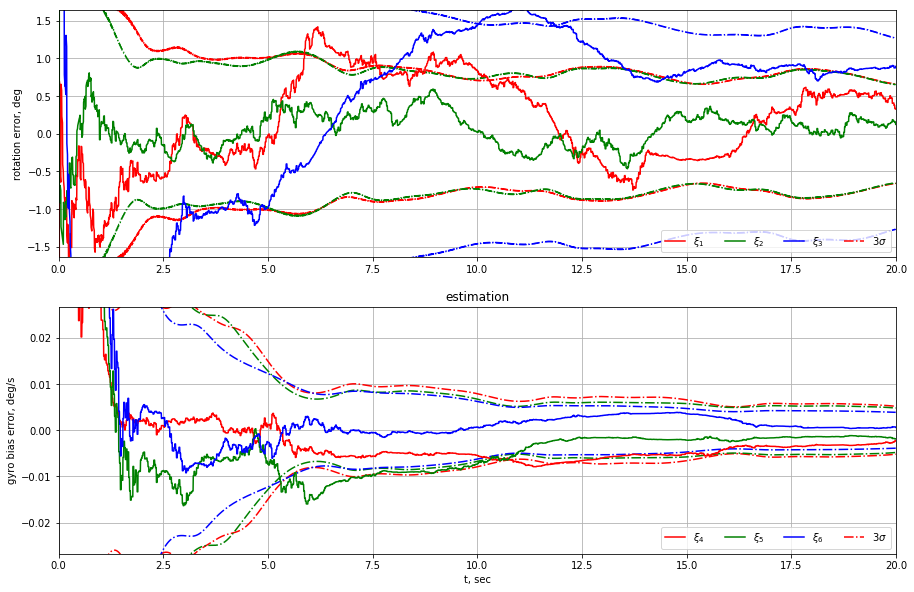

[ 0.08373246  0.29555121  1.69695246  0.0368211   0.04590157 -0.21998422]
error statistics after 10 seconds
mean (deg)	:    -0.0696 roll,     0.1591 pitch,    -0.2790 yaw
std  (deg)	:     0.1334 roll,     0.6488 pitch,     0.2662 yaw


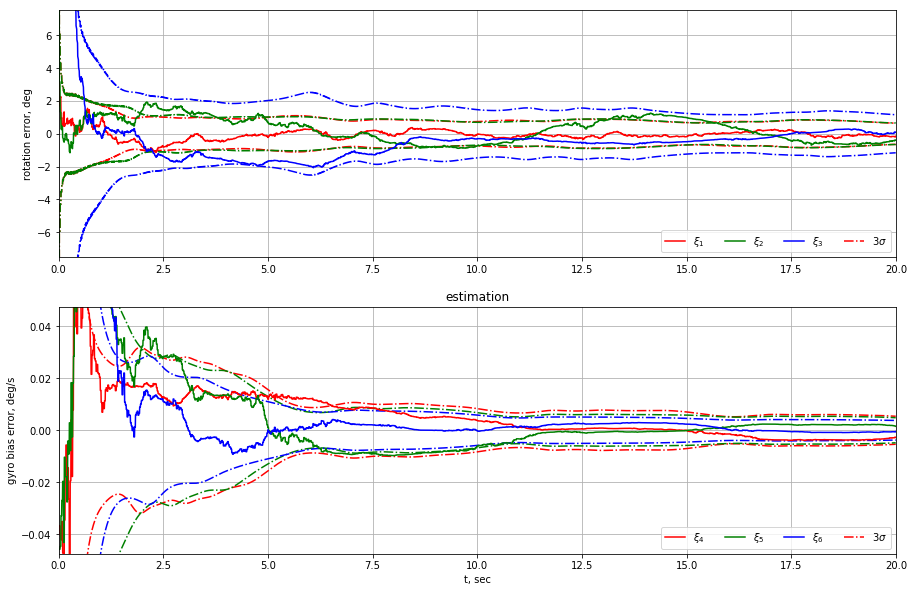

[ 9.93374129e-02  2.60047180e+00 -9.86637419e-01 -4.65926504e-02
 -2.25852734e-03 -6.64868382e-02]
error statistics after 10 seconds
mean (deg)	:    -0.1260 roll,     0.0276 pitch,    -0.1095 yaw
std  (deg)	:     0.3554 roll,     0.6469 pitch,     0.3860 yaw


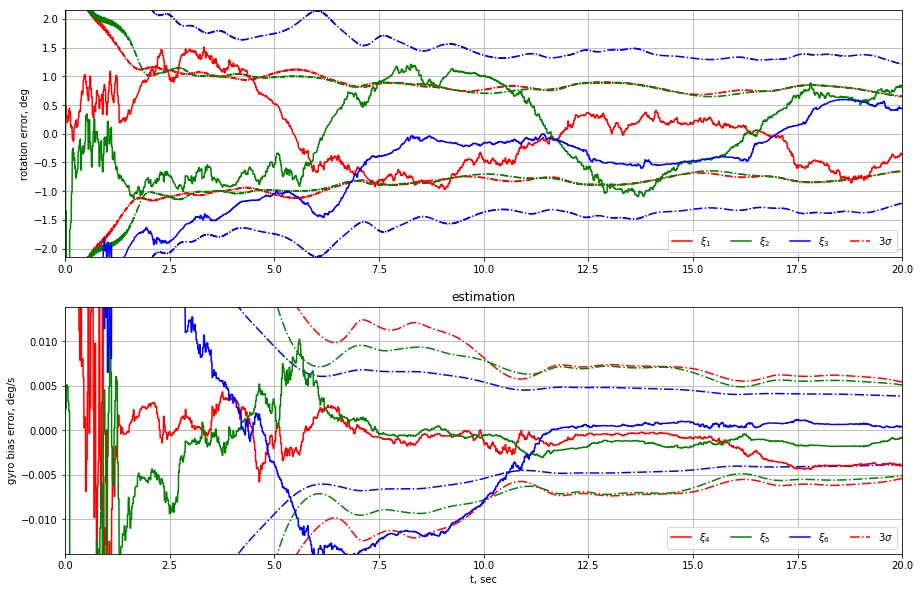

[-9.13371824e-01  2.51132342e+00 -1.06470407e+00 -1.60279694e-03
  3.28151172e-01 -2.88148422e-01]
error statistics after 10 seconds
mean (deg)	:    -0.1630 roll,     0.0394 pitch,     0.3601 yaw
std  (deg)	:     0.3619 roll,     0.3378 pitch,     0.3399 yaw


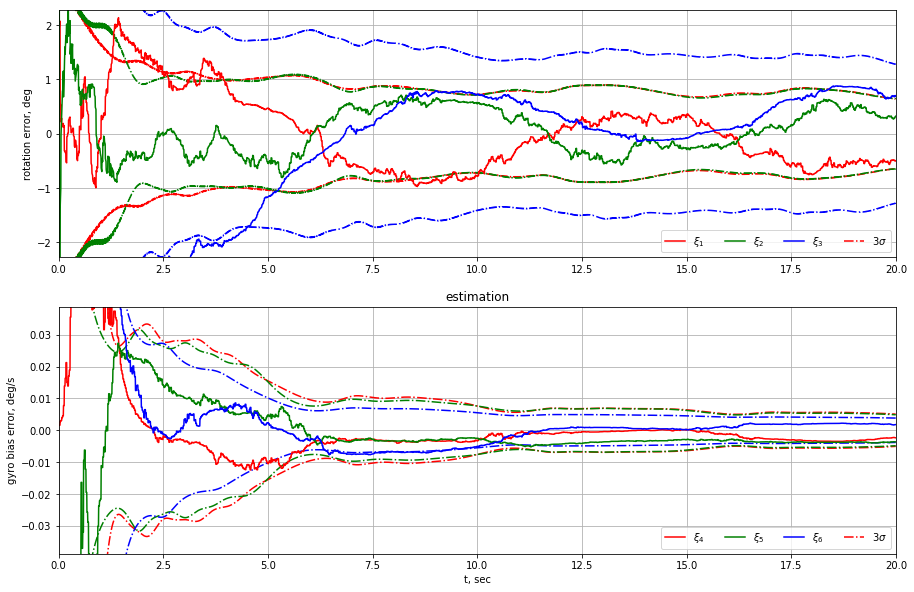

[-0.66475926  1.58738741 -0.91297984 -0.00251864 -0.21642467 -0.0282626 ]
error statistics after 10 seconds
mean (deg)	:    -0.0287 roll,     0.0699 pitch,    -0.4616 yaw
std  (deg)	:     0.8341 roll,     0.2497 pitch,     0.5126 yaw


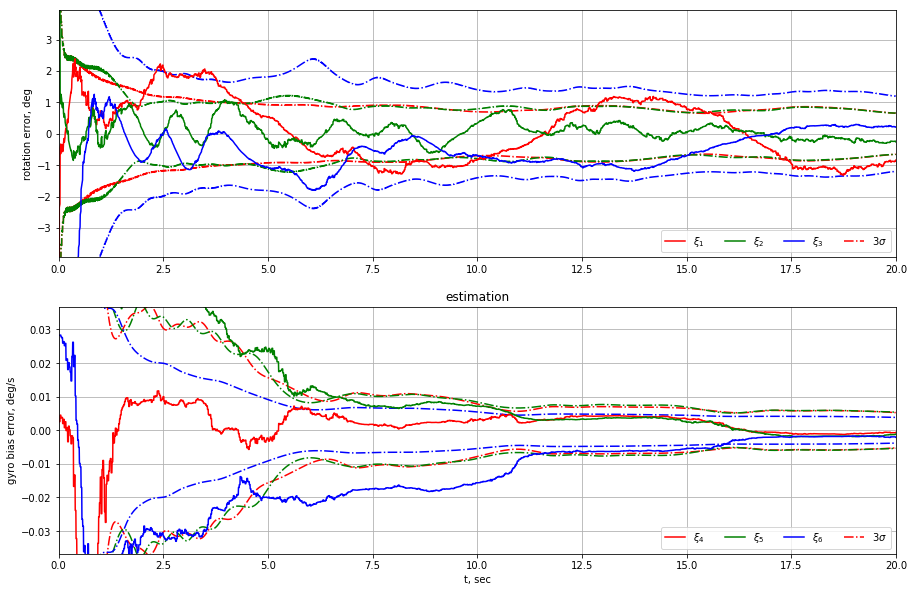

[ 0.91493898  1.66349641 -2.7901891  -0.05446976 -0.06587251 -0.05938342]
error statistics after 10 seconds
mean (deg)	:    -0.0879 roll,    -0.0066 pitch,    -0.1354 yaw
std  (deg)	:     0.3448 roll,     0.7915 pitch,     0.2221 yaw


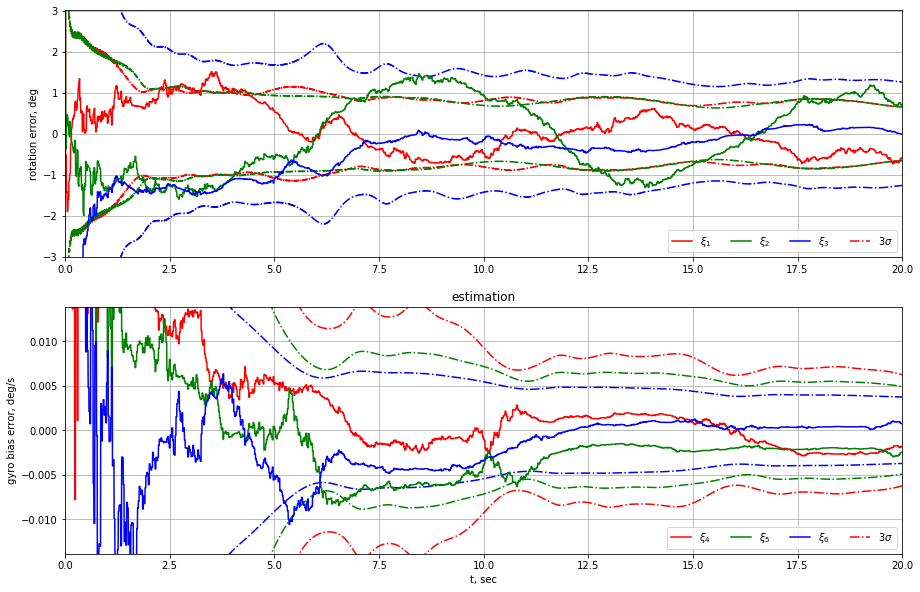

[-2.23314553 -1.26731407 -1.61449374  0.02964001 -0.16350192 -0.05516972]
error statistics after 10 seconds
mean (deg)	:     0.0375 roll,     0.0469 pitch,     0.4111 yaw
std  (deg)	:     0.5217 roll,     0.4161 pitch,     0.1476 yaw


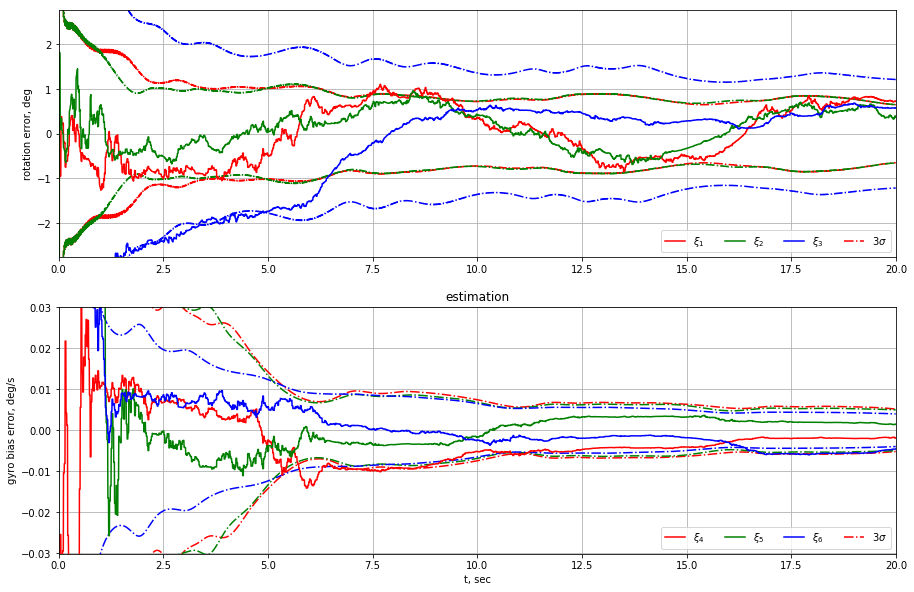

[-0.91634755 -0.56432234 -0.63205194  0.21511404 -0.02279589 -0.2342827 ]
error statistics after 10 seconds
mean (deg)	:     0.0483 roll,     0.0668 pitch,     0.7306 yaw
std  (deg)	:     0.7887 roll,     0.4131 pitch,     0.3062 yaw


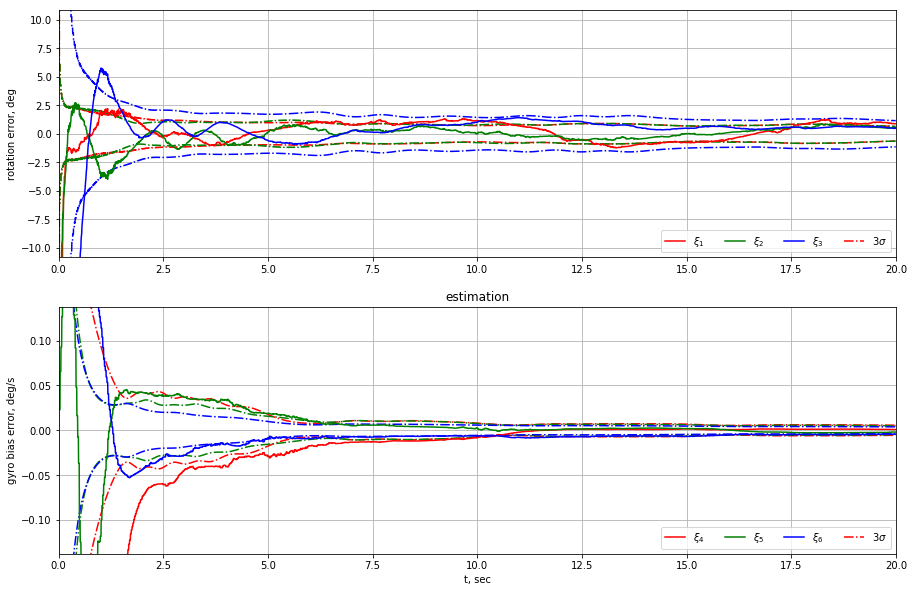

[-0.89287569 -1.62723444  0.3917716   0.06440929 -0.01102851  0.15503237]
error statistics after 10 seconds
mean (deg)	:     0.2693 roll,    -0.0314 pitch,    -0.2380 yaw
std  (deg)	:     0.6770 roll,     0.3911 pitch,     0.3481 yaw


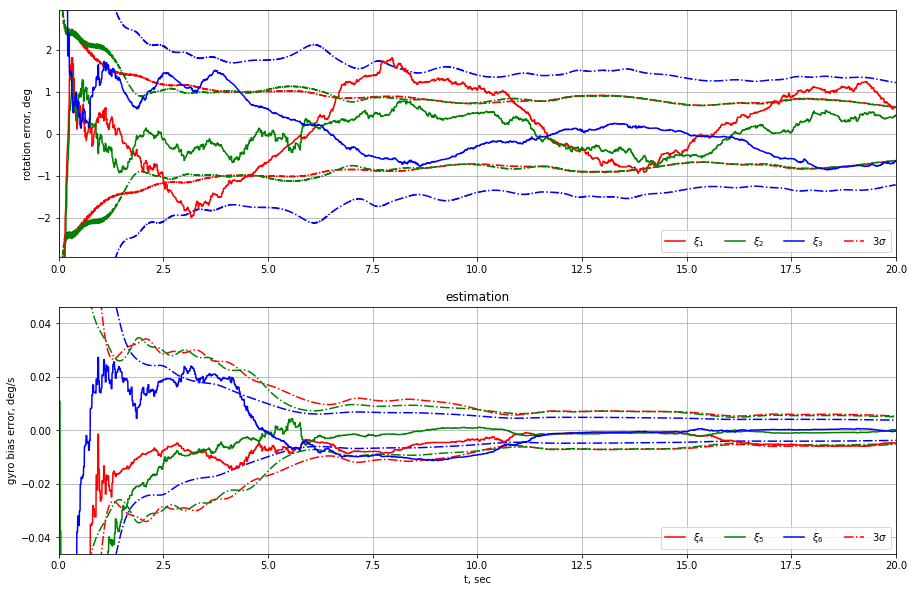

[ 0.03217437  0.08059838  0.73795736  0.16029354 -0.08313211  0.01333598]
error statistics after 10 seconds
mean (deg)	:    -0.0887 roll,    -0.0064 pitch,    -0.1142 yaw
std  (deg)	:     0.7350 roll,     0.1740 pitch,     0.3683 yaw


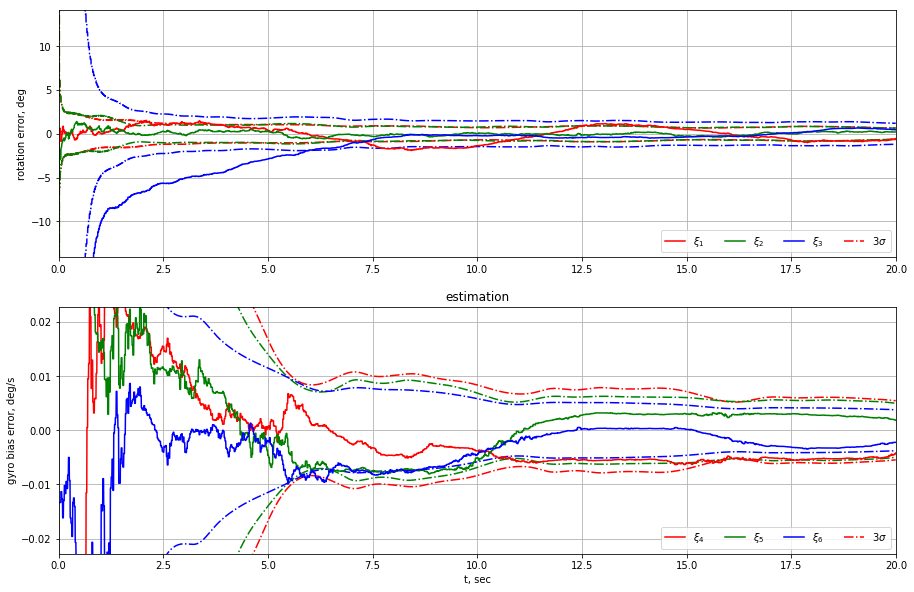

In [27]:
sim_params['tf'] = 20
for i in range(10):
    sim_params['x0'] = np.random.randn(6)*np.array([1, 1, 1, 0.1, 0.1, 0.1])
    print(sim_params['x0'])
    hist = sim(sim_funcs, sim_params)
    mean, std = analyze_hist(hist, sim_params['tf']/2)
    #if np.max(np.fabs(mean)) > 1 or np.max(np.fabs(mean)) > 1:
    plot_hist(hist, att=False, meas=False)
    sys.stdout.flush()

In [28]:
#%prun -l 5 hist = sim(sim_funcs, sim_params) #run this to profile, 10% slower
sim_params['tf'] = 30
sim_params['x0'] = np.array([-0.4, 0.1, 0.3, 0.1, 0.2, 0.3])
hist = sim(sim_funcs, sim_params)

error statistics after 15 seconds
mean (deg)	:    -0.0418 roll,     0.0387 pitch,     0.0642 yaw
std  (deg)	:     0.3142 roll,     0.5957 pitch,     0.1643 yaw


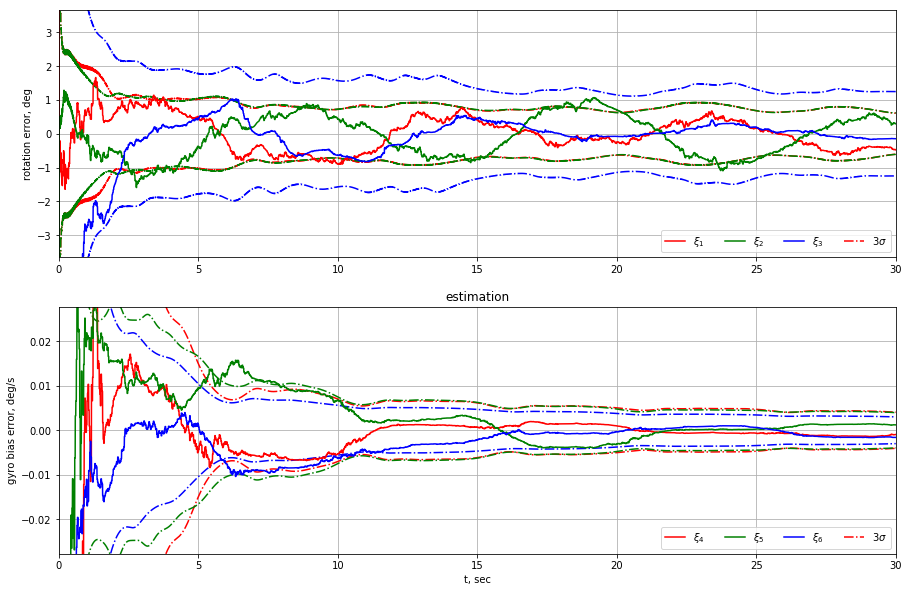

In [29]:
analyze_hist(hist, sim_params['tf']/2)
plot_hist(hist, meas=False, att=False)

# Code Generation

All of the functions that will be generated for the embedded system are listed below:

In [68]:
func

{'mrp_shadow': Function(mrp_shadow:(r[3])->(r_s[3]) SXFunction),
 'mrp_to_quat': Function(mrp_to_quat:(r[3])->(q[4]) SXFunction),
 'quat_to_euler': Function(quat_to_euler:(q[4])->(e[3]) SXFunction),
 'dP': Function(dP:(x_h[6],PU[6x6,18nz],w_att,omega_b[3])->(dP[6x6,27nz]) SXFunction),
 'predict_W': Function(predict_W:(x_h[6],W0[6x6,21nz],w_att,omega_b[3],dt)->(W1[6x6,21nz]) SXFunction),
 'predict_x': Function(x_predict:(x0[6],omega_b[3],dt)->(x1[6]) SXFunction),
 'correct_accel_sqrt': Function(correct_accel_sqrt:(i0[6],i1[6x6,21nz],i2[3],i3)->(o0[6],o1[6x6,21nz]) SXFunction),
 'correct_mag_sqrt': Function(correct_mag_sqrt:(i0[6],i1[6x6,21nz],i2[3],i3[3],i4)->(o0[6],o1[6x6,21nz]) SXFunction)}

In [69]:
# code generation
gen = ca.CodeGenerator('casadi_att_lgpekf.c', {'main': False, 'mex': False, 'with_header': True, 'with_mem': True})
for f_name in func:
    gen.add(func[f_name])
gen.generate('/home/jgoppert/git/phd/px4/src/modules/cei/ekf/')

'/home/jgoppert/git/phd/px4/src/modules/cei/ekf/casadi_att_lgpekf.c'